# 1. Introdução

Nesta primeira etapa do projeto, vamos realizar a leitura do conjunto de dados e executar a fase de pré-processamento e limpeza.

As análises iniciais incluem:

- verificar tipagem dos dados
- verificar a existência de valores ausentes
- remover valores ausentes, duplicados ou inconsistentes

## Características consideradas na limpeza dos dados

- Tipo do dados
- Percentual de valores ausentes
- Quantidade de valores únicos
- Percentual de valores únicos

## Metadados


Descrição resumida
> Base de dados de um datacenter de uma empresa de tecnologia com 720 linhas e 12 colunas

- timestamp (datetime64[ns]): Ano, mês e dia do evento
- hora_dia (int64): Hora do evento
- dia_semana (int64): Dia da semana
- reqs (int64): Número de requisições via app
- trafego_MBps (int64): Quantidade de dados em tráfego (MBps)
- usuarios_ativos (int64): Quantidade de usuários ativos
- temp_ambiente_C (float64): Temperatura ambiente em graus Celsius
- uso_cpu_% (float64): Percentual de uso de CPU
- uso_ram_% (float64): Percentual de uso de memória RAM
- demanda_energia_KW (float64): Demanda energética estimada
- pressao_resfriamento_bar (float64): Pressão de resfriamento (bar)
- consumo_agua_m3 (float64): Consumo de água (m3)

## Importando pacotes necessários e carregando funções úteis

In [ ]:
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from scipy.stats import skew, kurtosis
import pyarrow

def resume_df(df):

  df_aux = pd.DataFrame(index=df.columns)
  df_aux["Tipo"] = df.dtypes
  df_aux["Valores Ausentes"] = df.isna().sum()
  df_aux["Valores Ausentes [%]"] = round(100*df.isna().sum()/df.shape[0],2)
  df_aux["Valores Únicos"] = df.nunique()
  df_aux["Valores Únicos [%]"] = round(100*df_aux["Valores Únicos"]/df.shape[0],2)
  print(f'Número de linhas duplicadas encontradas na base de dados: {df.duplicated().sum()}')
  
  return df_aux

def estatisticas_df(df):
  
  df_aux = pd.DataFrame(index=df.columns)
  df_aux["Mínimo"] = df.apply(np.nanmin, axis=0)
  df_aux["Máximo"] = df.apply(np.nanmax, axis=0)
  df_aux["Mediana"] = df.apply(np.nanmedian, axis=0)
  df_aux["Média"] = df.apply(np.nanmean, axis=0)
  df_aux["Desvio Padrão"] = df.apply(np.nanstd, axis=0)
  df_aux["Obliquidade"] = df.apply(lambda x: skew(x, nan_policy='omit'), axis=0)
  df_aux["Curtose"] = df.apply(lambda x: kurtosis(x, nan_policy='omit'), axis=0)
  df_aux["Número Outliers"] = df.apply(existem_outliers, axis=0)

  return df_aux

def existem_outliers(s) -> int:

    s = s.dropna()
    q1 = np.quantile(s,.25)
    q3 = np.quantile(s,.75)
    iiq = q3 - q1
    ls = q3 + 1.5*iiq
    li = q1 - 1.5*iiq

    return len(s[(s>ls)|(s<li)])

In [2]:
# Leitura e resumo da base de dados
df = pd.read_csv('data_center_prob_estat.csv')
df.head()

,timestamp,hora_dia,dia_semana,reqs,trafego_MBps,usuarios_ativos,temp_ambiente_C,uso_cpu_%,uso_ram_%,demanda_energia_kW,pressao_resfriamento_bar,consumo_agua_m3
0,2025-04-27 00:00:00,0.0,6.0,69449.0,29.0,117723.0,19.672732,49.974899,45.599667,530.079647,1.744965,6.608988
1,2025-04-27 01:00:00,1.0,6.0,47088.0,10.0,114217.0,24.028354,50.298075,49.531911,520.202647,1.811916,5.987423
2,2025-04-27 02:00:00,2.0,6.0,53537.0,26.0,129156.0,25.782895,51.616842,45.111778,536.064628,1.844828,6.563108
3,2025-04-27 03:00:00,3.0,6.0,79260.0,25.0,147527.0,27.602470,48.271437,35.288168,515.557007,1.855394,6.816760
4,2025-04-27 04:00:00,4.0,6.0,32243.0,10.0,135722.0,26.728760,49.214139,44.555132,532.525342,1.847002,6.027148


In [3]:
resume_df(df)

Número de linhas duplicadas encontradas na base de dados: 0


,Tipo,Valores Ausentes,Valores Ausentes [%],Valores Únicos,Valores Únicos [%]
timestamp,object,12,1.67,708,98.33
hora_dia,float64,4,0.56,24,3.33
dia_semana,float64,7,0.97,7,0.97
reqs,float64,8,1.11,711,98.75
trafego_MBps,float64,6,0.83,67,9.31
usuarios_ativos,float64,11,1.53,708,98.33
temp_ambiente_C,float64,11,1.53,709,98.47
uso_cpu_%,float64,10,1.39,710,98.61
uso_ram_%,float64,10,1.39,710,98.61
demanda_energia_kW,float64,7,0.97,713,99.03


## Verificando correlação entre nulos

<Axes: >

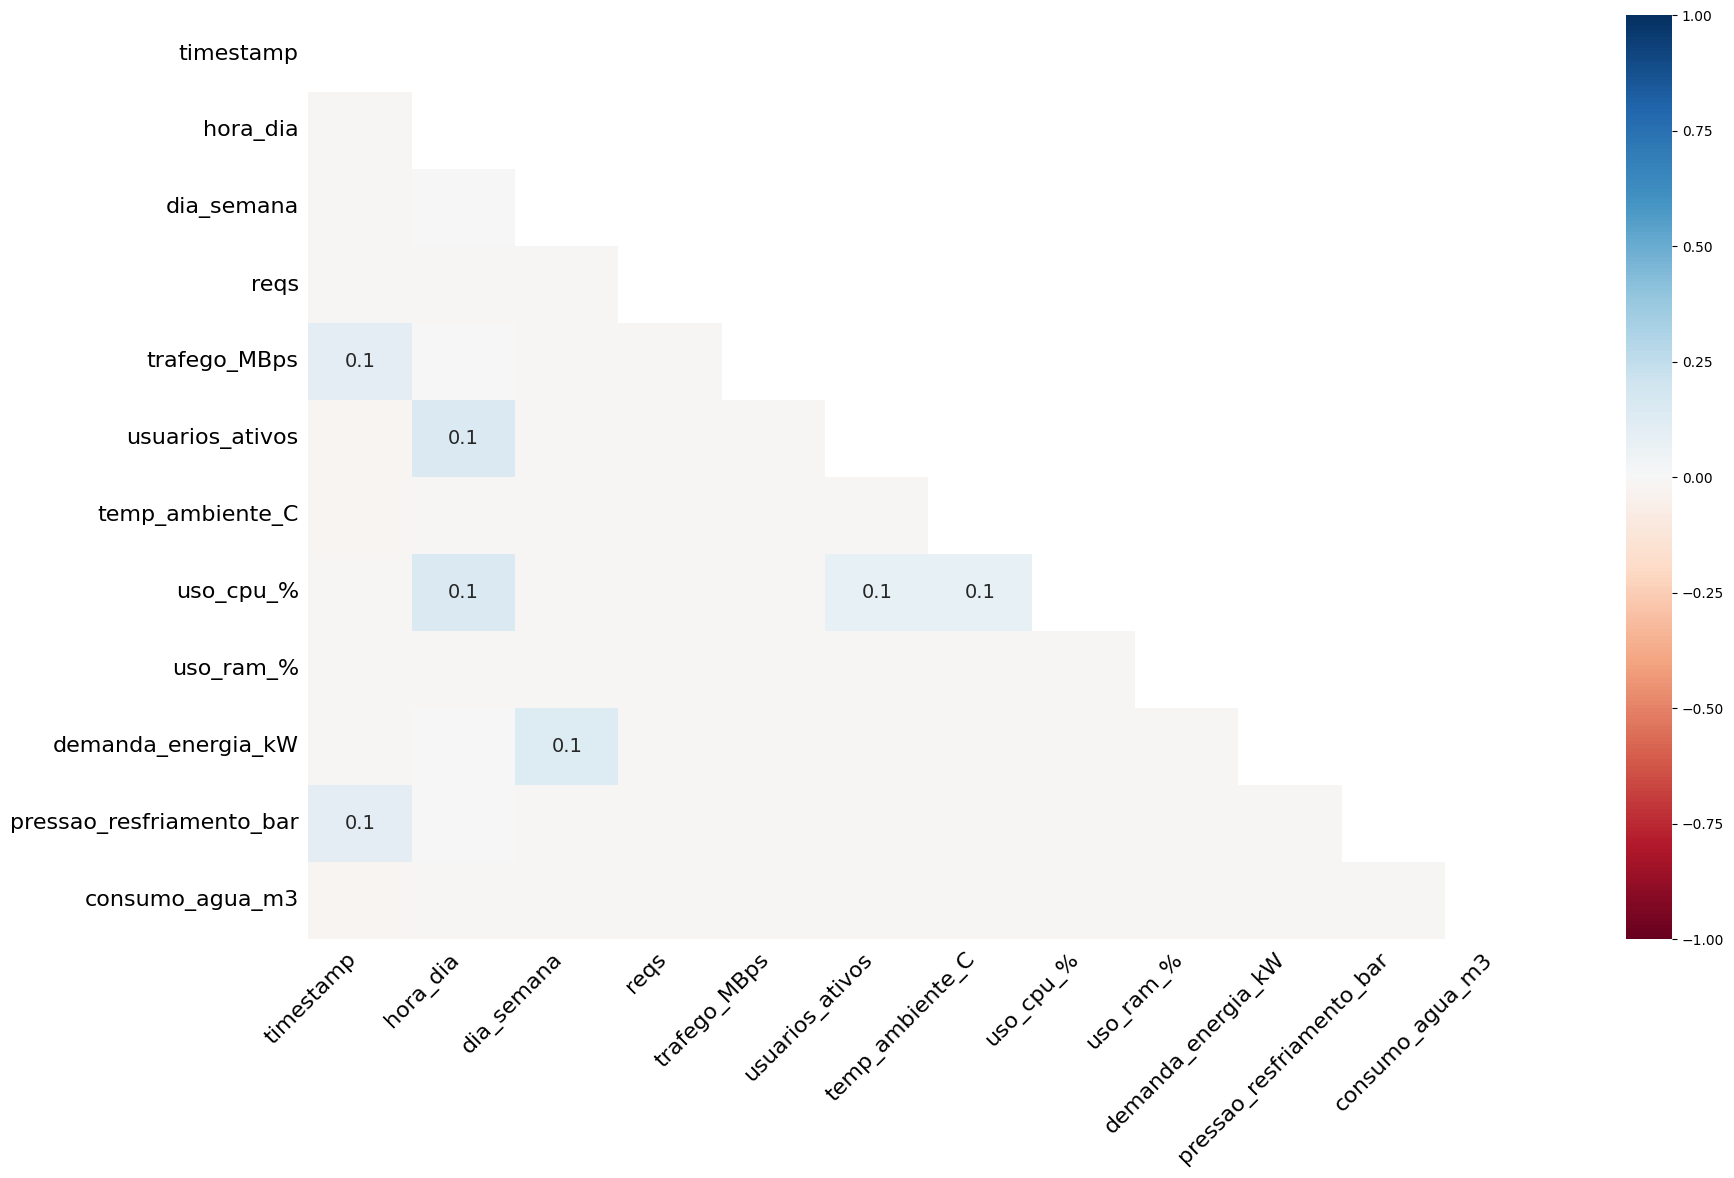

In [4]:
msno.heatmap(df)

In [5]:
# Medição da correlação monotônica entre os atributos
df.isna().astype(int).corr(method="spearman")

,timestamp,hora_dia,dia_semana,reqs,trafego_MBps,usuarios_ativos,temp_ambiente_C,uso_cpu_%,uso_ram_%,demanda_energia_kW,pressao_resfriamento_bar,consumo_agua_m3
timestamp,1.000000,-0.009731,-0.012900,-0.013800,0.107410,-0.016216,-0.016216,-0.015451,-0.015451,-0.012900,0.107410,-0.016216
hora_dia,-0.009731,1.000000,-0.007406,-0.007923,-0.006852,0.143034,-0.009310,0.150797,-0.008870,-0.007406,-0.006852,-0.009310
dia_semana,-0.012900,-0.007406,1.000000,-0.010503,-0.009083,-0.012342,-0.012342,-0.011759,-0.011759,0.134442,-0.009083,-0.012342
reqs,-0.013800,-0.007923,-0.010503,1.000000,-0.009717,-0.013203,-0.013203,-0.012580,-0.012580,-0.010503,-0.009717,-0.013203
trafego_MBps,0.107410,-0.006852,-0.009083,-0.009717,1.000000,-0.011418,-0.011418,-0.010879,-0.010879,-0.009083,-0.008403,-0.011418
usuarios_ativos,-0.016216,0.143034,-0.012342,-0.013203,-0.011418,1.000000,-0.015515,0.081975,-0.014782,-0.012342,-0.011418,-0.015515
temp_ambiente_C,-0.016216,-0.009310,-0.012342,-0.013203,-0.011418,-0.015515,1.000000,0.081975,-0.014782,-0.012342,-0.011418,-0.015515
uso_cpu_%,-0.015451,0.150797,-0.011759,-0.012580,-0.010879,0.081975,0.081975,1.000000,-0.014085,-0.011759,-0.010879,-0.014782
uso_ram_%,-0.015451,-0.008870,-0.011759,-0.012580,-0.010879,-0.014782,-0.014782,-0.014085,1.000000,-0.011759,-0.010879,-0.014782
demanda_energia_kW,-0.012900,-0.007406,0.134442,-0.010503,-0.009083,-0.012342,-0.012342,-0.011759,-0.011759,1.000000,-0.009083,-0.012342


## Conclusão

- Não existe forte correlação entre os valores faltantes
- Observa-se pelo heatmap da biblioteca missingno que não há forte correlação entre os valores nulos

In [6]:
df.iloc[540:550, :]

,timestamp,hora_dia,dia_semana,reqs,trafego_MBps,usuarios_ativos,temp_ambiente_C,uso_cpu_%,uso_ram_%,demanda_energia_kW,pressao_resfriamento_bar,consumo_agua_m3
540,2025-05-19 12:00:00,12.0,0.0,108374.0,50.0,199659.0,23.212054,53.792629,47.781040,533.826238,1.817144,6.381581
541,2025-05-19 13:00:00,13.0,0.0,101140.0,36.0,191467.0,19.692625,41.205914,47.659335,495.572476,1.701419,6.389734
542,2025-05-19 14:00:00,14.0,0.0,108081.0,40.0,190465.0,19.364360,48.649466,38.015444,526.739840,1.733713,6.833106
543,2025-05-19 15:00:00,15.0,0.0,86189.0,24.0,164156.0,18.491452,59.108888,44.860531,574.375413,1.772916,5.956366
544,2025-05-19 16:00:00,16.0,0.0,102540.0,45.0,171155.0,15.842434,47.067630,40.143862,520.051040,1.672975,6.152785
545,2025-05-19 17:00:00,17.0,0.0,78794.0,24.0,166228.0,17.641161,47.463675,48.969065,504.426199,1.701936,NaN
546,2025-05-19 18:00:00,18.0,0.0,98331.0,37.0,156104.0,19.099244,48.510717,48.699479,512.261355,1.729042,6.005322
547,NaN,19.0,0.0,86441.0,27.0,162379.0,16.224949,44.467699,41.814188,514.691220,1.665713,6.143645
548,2025-05-19 20:00:00,NaN,0.0,133450.0,43.0,163070.0,20.108622,NaN,42.591456,480.327623,1.700793,5.681810
549,2025-05-19 21:00:00,21.0,0.0,118541.0,38.0,172644.0,19.903235,49.614283,43.730343,508.559567,1.746620,5.723457


## Eliminando valores nulos na coluna "timestamp"

- Observa-se que os valores faltantes seguem a sequência temporal (de hora em hora)
- A coluna timestamp será substituída por uma sequência temporal e os atributos provenientes dessa coluna também serão adicionados

In [7]:
df["timestamp"].iloc[0]

'2025-04-27 00:00:00'

In [8]:
df["timestamp"].iloc[-1]

'2025-05-26 23:00:00'

In [9]:
df["timestamp"] = pd.date_range(start=df.timestamp.iloc[0], end=df.timestamp.iloc[-1], freq="1h" )
df["hora_dia"] = df["timestamp"].apply(lambda x:x.hour)
df["dia_semana"] = df["timestamp"].apply(lambda x:x.dayofweek)


In [10]:
resume_df(df)

Número de linhas duplicadas encontradas na base de dados: 0


,Tipo,Valores Ausentes,Valores Ausentes [%],Valores Únicos,Valores Únicos [%]
timestamp,datetime64[ns],0,0.00,720,100.00
hora_dia,int64,0,0.00,24,3.33
dia_semana,int64,0,0.00,7,0.97
reqs,float64,8,1.11,711,98.75
trafego_MBps,float64,6,0.83,67,9.31
usuarios_ativos,float64,11,1.53,708,98.33
temp_ambiente_C,float64,11,1.53,709,98.47
uso_cpu_%,float64,10,1.39,710,98.61
uso_ram_%,float64,10,1.39,710,98.61
demanda_energia_kW,float64,7,0.97,713,99.03


In [11]:
df.dtypes

timestamp                   datetime64[ns]
hora_dia                             int64
dia_semana                           int64
reqs                               float64
trafego_MBps                       float64
usuarios_ativos                    float64
temp_ambiente_C                    float64
uso_cpu_%                          float64
uso_ram_%                          float64
demanda_energia_kW                 float64
pressao_resfriamento_bar           float64
consumo_agua_m3                    float64
dtype: object

In [12]:
# Transformando o índice em valores temporais para realizar a interpolação
df = df.set_index(df["timestamp"]).drop(columns=["timestamp"]).copy()

# Realizando a interpolação para os atributos que não são provenientes do tempo
for c in df.columns:
    if df[c].isna().sum() > 0:
        df[c] = df[c].interpolate(method="time").copy()

In [13]:
df.columns

Index(['hora_dia', 'dia_semana', 'reqs', 'trafego_MBps', 'usuarios_ativos',
       'temp_ambiente_C', 'uso_cpu_%', 'uso_ram_%', 'demanda_energia_kW',
       'pressao_resfriamento_bar', 'consumo_agua_m3'],
      dtype='object')

## Atributos que terão sua tipagem modificada para "integer"

- hora_dia
- dia_semana
- reqs
- usuarios_ativos

In [14]:
df[["hora_dia", "dia_semana", "reqs", "usuarios_ativos"]] = df[["hora_dia", "dia_semana", "reqs", "usuarios_ativos"]].apply(lambda x:x.astype(int)).copy()
resume_df(df)

Número de linhas duplicadas encontradas na base de dados: 0


,Tipo,Valores Ausentes,Valores Ausentes [%],Valores Únicos,Valores Únicos [%]
hora_dia,int32,0,0.0,24,3.33
dia_semana,int32,0,0.0,7,0.97
reqs,int32,0,0.0,719,99.86
trafego_MBps,float64,0,0.0,68,9.44
usuarios_ativos,int32,0,0.0,719,99.86
temp_ambiente_C,float64,0,0.0,719,99.86
uso_cpu_%,float64,0,0.0,720,100.00
uso_ram_%,float64,0,0.0,720,100.00
demanda_energia_kW,float64,0,0.0,720,100.00
pressao_resfriamento_bar,float64,0,0.0,720,100.00


In [15]:
df.head(5)

,hora_dia,dia_semana,reqs,trafego_MBps,usuarios_ativos,temp_ambiente_C,uso_cpu_%,uso_ram_%,demanda_energia_kW,pressao_resfriamento_bar,consumo_agua_m3
timestamp,,,,,,,,,,,
2025-04-27 00:00:00,0,6,69449,29.0,117723,19.672732,49.974899,45.599667,530.079647,1.744965,6.608988
2025-04-27 01:00:00,1,6,47088,10.0,114217,24.028354,50.298075,49.531911,520.202647,1.811916,5.987423
2025-04-27 02:00:00,2,6,53537,26.0,129156,25.782895,51.616842,45.111778,536.064628,1.844828,6.563108
2025-04-27 03:00:00,3,6,79260,25.0,147527,27.602470,48.271437,35.288168,515.557007,1.855394,6.816760
2025-04-27 04:00:00,4,6,32243,10.0,135722,26.728760,49.214139,44.555132,532.525342,1.847002,6.027148


In [16]:
# Salvando os dados limpos
df.to_parquet("data_center_limpo.parquet")